In [1]:
'''
To run hit Kernel > restart & run all.

Scroll to the bottom to select the gft and fasta files with the drop down.

Resulting graphs and analysis will be output below
'''

'\nTo run hit Kernel > restart & run all.\n\nScroll to the bottom to select the gft and fasta files with the drop down.\n\nResulting graphs and analysis will be output below\n'

In [2]:
''' If you have issues with unfound packages, uncomment the pip install lines below'''
# ! pip install ipywidgets
# ! pip install matplotlib
# ! pip install pandas

! jupyter nbextension enable --py widgetsnbextension
''' If you have issues with unfound packages, uncomment the pip install lines above'''

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


' If you have issues with unfound packages, uncomment the pip install lines above'

In [3]:
from ipywidgets import *
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from ipywidgets import HBox, Label

# %matplotlib inline

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
class FileType(Enum):
    UNSUPPORTED = 0
    FASTA = 1
    GFT = 2
    
summary = {}
NUMBER_MISMATCHES = 0

In [11]:
def graph_data(series):
    plt.plot(series)
    plt.ylabel('Y label')
    plt.xlabel('X label')
    plt.title('Title')
    plt.show()
    return plt

def read_gft(filename):
    gft = pd.read_csv(filename, sep=r'[;\t]', 
                     header=None, 
                     names=["seqname", "source", "feature", "coordinate1", "coordinate2", "score", "orientation", "frame", 
                            "gene_id", "transcript_id", "drop_me"],
                     engine='python')
    gft = gft.drop("drop_me", axis=1)
    return gft

def get_avg_gene_span(gft):
    spans = []
    for gid in gft.gene_id.unique():
        exon_coordinate_list = (gft[ gft.gene_id == gid].coordinate1).append(gft[ gft.gene_id == gid].coordinate2)
        gene_span = exon_coordinate_list.max() - exon_coordinate_list.min() + 1
        spans.append(gene_span)
    return pd.Series(spans).mean()

def get_avg_intergenic_space(gft):
    # intergenic space is min cordinate 1 of gene 2      max cordinate 2 of gene 1
    spacing = pd.DataFrame()
    spacing["left"] = gft.groupby("gene_id").coordinate1.min()
    spacing["right"] = gft.groupby("gene_id").coordinate1.max()
    diff = []
    for r in range(0, len(spacing) - 1):
        diff.append(spacing.iloc[r + 1].right - spacing.iloc[r].left)
    return pd.Series(diff).mean()

def get_avg_length(gft, condition):
    gft = gft[condition]
    spacing = pd.DataFrame()
    spacing["left"] = gft.coordinate1
    spacing["right"] = gft.coordinate2
    diff = []
    for r in range(0, len(spacing) - 1):
            diff.append(spacing.iloc[r].left - spacing.iloc[r + 1].right + 1)
    return pd.Series(diff).mean()

def find_200_before_gene(gft):
    starts = {}
    mi = gft.groupby("gene_id").min()
    ma = gft.groupby("gene_id").max()

    for n in ma[ma.orientation == '-'].index:
        starts[str(n)] = (ma.loc[n].coordinate2, ma.loc[n].coordinate2 + 200)

    for n in mi[mi.orientation == '+'].index:
        starts[str(n)] = (mi.loc[n].coordinate1 - 200, mi.loc[n].coordinate1)
    return starts
    

def process_gft(gft):
    global summary
    summary["Number of Genes"] = gft.gene_id.nunique()
    summary["Gene Density"] = gft.gene_id.nunique() / gft.gene_id.count()
    summary["Average Gene Span"] = get_avg_gene_span(gft[gft.feature != "stop_codon"])
    summary["Average Intergenic Spaces"] = get_avg_intergenic_space(gft) 
    
    summary["Average Intron Length"] = abs(get_avg_length(gft, gft.feature == "exon"))
    
    summary["Number of Exons"] = gft[gft.feature == "exon"].seqname.count()
    summary["Number of Introns"] = summary["Number of Exons"] - 1
    summary["Average Exon Length"] = (gft[gft.feature != "stop_codon"].coordinate2 - gft[gft.feature != "stop_codon"].coordinate1 + 1).mean()
    
    summary["Average GC Content"] = "Use information from the fasta file!"
    
    summary["Starts"] = find_200_before_gene(gft)
    return summary
    
def read_lab1(filename):
    seq = ""
    with open(filename) as file:
        line1 = file.readline()
        seq = file.read().replace('\n', "").replace('\t', "")
    d = {'A': [], 'C': [], 'G': [], 'T': [], 'N': []}
    for s in seq:
        d[s].append(1)
        for k in d.keys():
            if k is not s:
                d[k].append(0)
    df = pd.DataFrame(d)
    return df
    
def analyze_lab1(df):
    total_gc = df.C.mean() + df.G.mean()
    global summary 
    summary["Average GC Content"] = total_gc
    summary["Total Unknown"] = df.N.mean()
    
    s = int(df.shape[0])
    window_size = int(s / 20)
    plt.plot(total_gc)
    off = int(s/float(66.6))

    # TODO make this better. 
    if off == 0:
        plt.plot(get_averages(df, s, window_size, offset=0)[0])
    else:
        for o in range(0, window_size, off):
            plt.plot(get_averages(df, s, window_size, offset=o)[0])

    plt.ylabel('Percentage')
    plt.xlabel('Window Number')
    
    locs = list(summary["Starts"].values())[0]
    print(locs)
    plt.title('GC Percentage from %s to %s' %(locs[0], locs[1]))
    plt.show()
    return plt

def get_averages(df, s, window_size, offset=0, print_me=False):
    rolling_avg = []
    window = []
    for i in range(offset, s, window_size):
        gc = df.iloc[i : i + window_size].G.mean() + df.iloc[i : i + window_size].C.mean()
        if print_me:
            print("window: ", i, i + window_size, "\t the gc content is: ", gc, "unknown: ", df.iloc[i : i + window_size].N.mean())
        rolling_avg.append(gc)
        window.append((i, i+window_size))
    return rolling_avg, window
    
def reverse_complement(seq):
    for k,v in alt_map.iteritems():
        seq = seq.replace(k,v)
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    for k,v in alt_map.iteritems():
        bases = bases.replace(v,k)
    return bases

def handle_gft(fname):
    filename = "data/" + fname
    file_type = FileType.GFT
    with open(filename) as file:
        line1 = file.readline()
        if line1[0] is '>':
            raise UserWarning("That file type is unsupported. Exiting.")
            sys.exit(-1)
    df = read_gft(filename)
    summary = process_gft(df)
    return summary

def handle_fasta(fname):
    filename = "data/" + fname
    file_type = FileType.FASTA
    with open(filename) as file:
        line1 = file.readline()
        if line1[0] is not '>':
            raise UserWarning("That file type is unsupported. Exiting.")
            sys.exit(-1)

    df = read_lab1(filename)
    # loop on analysis for each gene
    global summary        
    genes_start = summary["Starts"]
    
    for gene, locations in genes_start.items():
        upstream_region = df.loc[locations[0] : locations[1]]
        analyze_lab1(upstream_region)
        x = upstream_region.stack()
        up_list = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1))).tolist()
        print("Motif locations for", gene)
        motif_location = get_mos("".join(up_list))
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

    print("\n".join("{}: {}".format(k, v) for k, v in summary.items()))
    #     return plt_instance

In [12]:
def frequentWords( s, k ):
    counts = {}
    for i in range(0,len(s)-k+1):
        if "N" in s[i:i+k]:
            continue
        if s[i:i+k] not in counts:
            counts[s[i:i+k]] = 0
        counts[s[i:i+k]] += 1
    m = max(counts.values())
    
    top_counts = list(counts.values())
    top_counts.sort()
    top_counts = top_counts[-3:]
    
    out = []
    for kmer in counts:
        if k > 5 and (counts[kmer] in top_counts) and (counts[kmer] >= 2):
            out.append(kmer)
        elif counts[kmer] in top_counts and (counts[kmer] > 2):
            out.append(kmer)
    return out

In [13]:
import regex as re
def get_motifs_and_locations(f, seq):
    
    if NUMBER_MISMATCHES is not 0:
        error_string = "{e<=%d}" %NUMBER_MISMATCHES
    else:
        error_string = ""
    motif_location = {}
    
    for word in f:
        matches = re.finditer('(%s)%s'% (word, error_string) , seq, overlapped=True)
        for m in matches:
            loc = m.span()[0]
            phrase = m.group()
            
            fuzzy = ""
            if phrase not in motif_location:
                motif_location[phrase] = []
            if m.fuzzy_counts != (0,0,0):
                fuzzy = "*"
            motif_location[phrase].append(str(loc) + fuzzy)
    print("\n".join("{}: {}".format(k, v) for k, v in motif_location.items()))

In [14]:
def get_mos(my_sequence):
    for i in range(4, 11):
        f = frequentWords(my_sequence, i)
        if f:
            get_motifs_and_locations(f, my_sequence)
        else:
            break

Dropdown(description='GFT:', options=('gft1.txt', 'DNA.txt', 'customgft.txt', 'Imagine9GFF.txt', 'Contig4_GFT.…

Dropdown(description='FASTA:', options=('gft1.txt', 'DNA.txt', 'customgft.txt', 'Imagine9GFF.txt', 'Contig4_GF…

BoundedIntText(value=0, description='Mismatches : ', max=10)

(2362.0, 2562.0)


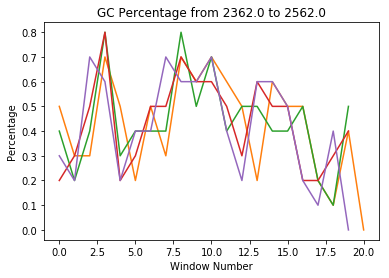

Motif locations for gene_id "Cpr76Bc"
TTCA: ['6*', '147*']
TATAA: ['12*']
ATAA: ['13*']
TAA: ['14*', '49*', '172*', '181*']
TTTA: ['47*', '57*', '131*']
TTAA: ['48', '132', '171', '180', '188']
TTAC: ['52*']
TTAG: ['58*']
TTGA: ['70*', '76*']
TAAA: ['133*', '189*']
ATTAA: ['170*', '179*']
CTTAA: ['187*']
AAAT: ['19*']
AATA: ['20*']
ACTT: ['23*']
AATG: ['31*']
TAATT: ['49*', '181*']
AATT: ['50', '169', '178', '182']
ATT: ['51*', '63*', '75*', '170*', '179*']
GATT: ['62*', '118*', '158*']
ACATT: ['73*']
CATT: ['74*']
ATTT: ['119*', '159*', '183*']
GAATT: ['168*', '177*']
AATC: ['173*']
AGG: ['16*', '60*', '101*']
CGCG: ['36*', '115*']
GCG: ['37*', '90*', '105*', '116*', '127*', '194*']
AACG: ['42*', '113*', '136*']
ACG: ['43*', '54*', '84*', '137*', '154*']
CAGCG: ['88*', '125*']
AGCG: ['89', '104', '126', '193']
ATCG: ['94*', '174*']
AGAG: ['99*']
GAGCG: ['103*']
AGCA: ['110*']
ACGCG: ['114*']
AGTG: ['143*', '150*']
AAGCG: ['192*']
AATGC: ['31*']
CAACGC: ['41*', '112*']
AACGC: ['42', '1

In [15]:
# This is the display UI code which calls event handler code
# get all the file names in the data folder and display for our users
files = [f for f in os.listdir('data') if os.path.isfile(os.path.join("data", f))]

gtf_dropdown = widgets.Dropdown(options= files, description= "GFT:")
fasta_dropdown = widgets.Dropdown(options= files, description= "FASTA:")
num_mismatches = widgets.BoundedIntText(
    value = 0,
    min = 0,
    max = 10,
    step=1,
    description='Mismatches : ',
    disabled=False
)

def is_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        return change['new']
    return None

def fasta_selection(dd):
    if is_change(dd):
        return handle_fasta(is_change(dd))
    return None

def gft_selection(dd):
    if is_change(dd):
        global summary
        summary = handle_gft(is_change(dd))

    return None

def mismatch_selection(dd):
    if is_change(dd):
        global NUMBER_MISMATCHES
        NUMBER_MISMATCHES = is_change(dd)

    return None


o = gtf_dropdown.observe(gft_selection)
o = fasta_dropdown.observe(fasta_selection)
num_mismatches.observe(mismatch_selection)

display(gtf_dropdown)
display(fasta_dropdown)
display(num_mismatches)